## Data Access demo

[OWSLib](https://geopython.github.io/OWSLib) is a Python package for client programming with Open Geospatial Consortium (OGC) web service (hence OWS) interface standards, and their related content models. In this demo we’ll work with the CSW, WMS and WCS interfaces.

In [61]:
from owslib.csw import CatalogueServiceWeb
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService
import lxml.etree
import requests
from tifffile import imread
from io import BytesIO, StringIO

### Data Discovery

The user has already discovered the dataset to use by using the OWSLib CSW client

In [2]:
base_domain = "demo.eoepca.org"
#base_domain = "develop.eoepca.org"
#base_domain = "185.52.193.87.nip.io"
workspace_prefix = "demo-user"
#workspace_prefix = "user"
system_endpoint = f'https://resource-catalogue.{base_domain}/csw'

In [6]:
csw = CatalogueServiceWeb(system_endpoint,timeout=30)

In [10]:
#scene_id='S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE'
#scene_id='S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE'
scene_id="S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE"

#scene_id='S2B_MSIL1C_20210402T095029_R079_T33UXQ_20210402T121737'

In [11]:
csw.getrecordbyid(id=[scene_id])

In [12]:
links = csw.records[scene_id].references

In [13]:
for link in links:
    scheme = link['scheme']
    if 'WMS' in scheme:
        wms_endpoint=link['url']
        print(link['url'])

https://data-access.demo.eoepca.org/ows?service=WMS&version=1.3.0&request=GetCapabilities&cql=identifier%3D%22S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE%22


### Data Visualization

After discovering the dataset, the user can identify the WMS link and use the OWSLib WMs client to visualize the dataset

In [20]:
wms = WebMapService(wms_endpoint, version='1.3.0')

The list of layers available to the WMS service:

In [21]:
list(wms.contents)

['S2B_MSIL1C_20210402T095029_R079_T33UXQ_20210402T121737',
 'S2B_MSIL1C_20210402T095029_R079_T33UXQ_20210402T121737__outlines',
 'S2B_MSIL1C_20210402T095029_R079_T33UXQ_20210402T121737__outlined',
 'S2B_MSIL1C_20210402T095029_R079_T33UXQ_20210402T121737__FALSE_COLOR',
 'S2B_MSIL1C_20210402T095029_R079_T33UXQ_20210402T121737__NDVI',
 'S2B_MSIL1C_20210402T095029_R079_T33UXQ_20210402T121737__TRUE_COLOR',
 'S2B_MSIL1C_20210402T095029_R079_T33UXQ_20210402T121737__clouds',
 'S2B_MSIL1C_20210402T095029_R079_T33UXQ_20210402T121737__masked_clouds']

Along with some WMS layer metadata:

In [22]:
wms[scene_id].title

'S2B_MSIL1C_20210402T095029_R079_T33UXQ_20210402T121737'

In [23]:
wms[scene_id].boundingBoxWGS84

(16.357910769851937, 48.62982157570405, 17.904572762902152, 49.64443670244057)

In [24]:
[op.name for op in wms.operations]

['GetCapabilities', 'GetMap', 'GetFeatureInfo']

In [25]:
wms[scene_id].styles

{}

In [26]:
wms.getOperationByName('GetMap').formatOptions

['image/png', 'image/jpeg', 'image/gif', 'image/tiff']

The user can visualize the WMS GetMap request from matplotlib

In [89]:
%matplotlib inline
import os, sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def getMap(wms,layerName,bbox,filename,style=None):
    wms.getOperationByName('GetMap').formatOptions
    img = wms.getmap(layers=[layerName],
                 styles=[style] if style is not None else None,
                 size=(600,300),
                 srs='EPSG:4326',
                 bbox=bbox,
                 format='image/png',
                 transparent=True)

    tmpfile = open(filename,'wb')
    tmpfile.write(img.read())
    tmpfile.close()

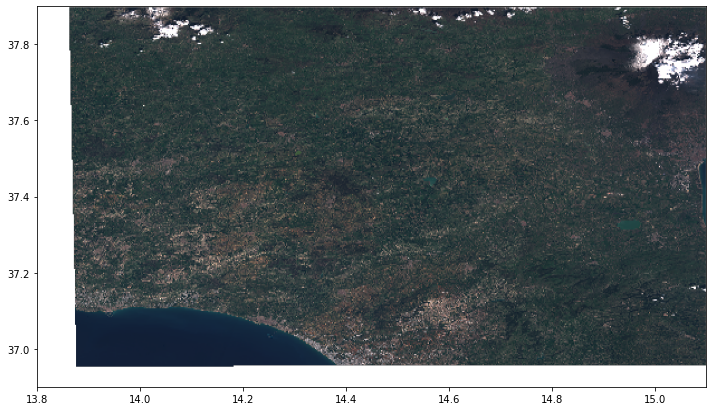

In [90]:
getMap(wms,'S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE__TRUE_COLOR',(13.8,36.9,15.1,37.9), 'rgb.png')
image1=mpimg.imread('rgb.png')
fig = plt.figure(figsize=(12,7))
img1=plt.imshow(image1,extent=[13.8,15.1,36.9,37.9],aspect='auto')
plt.show()

False color composite using Near Infrared, Red, Green Bands

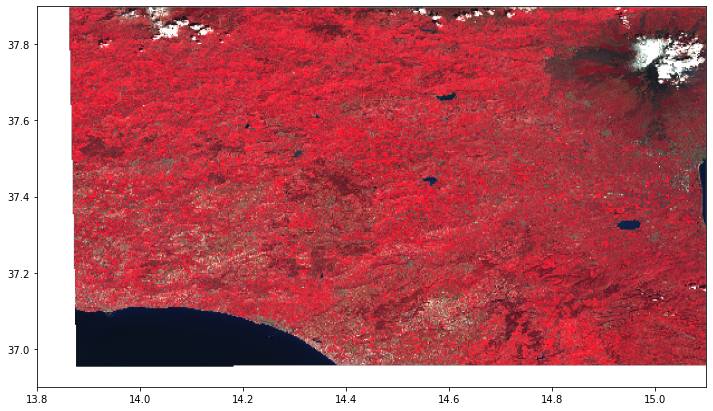

In [85]:
getMap(wms,'S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE__FALSE_COLOR',(13.8,36.9,15.1,37.9), 'nirrg.png')
image1=mpimg.imread('nirrg.png')
fig = plt.figure(figsize=(12,7))
img1=plt.imshow(image1,extent=[13.8,15.1,36.9,37.9],aspect='auto')
plt.show()

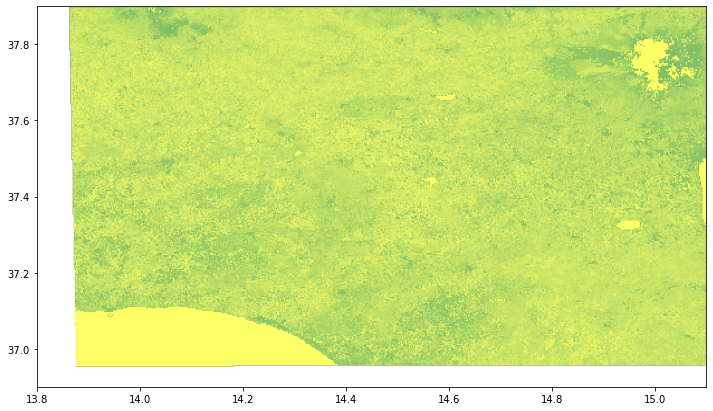

In [92]:
getMap(wms,'S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE__NDVI',(13.8,36.9,15.1,37.9), 'ndvi.png', style='summer')
image1=mpimg.imread('ndvi.png')
fig = plt.figure(figsize=(12,7))
img1=plt.imshow(image1,extent=[13.8,15.1,36.9,37.9],aspect='auto')
plt.show()

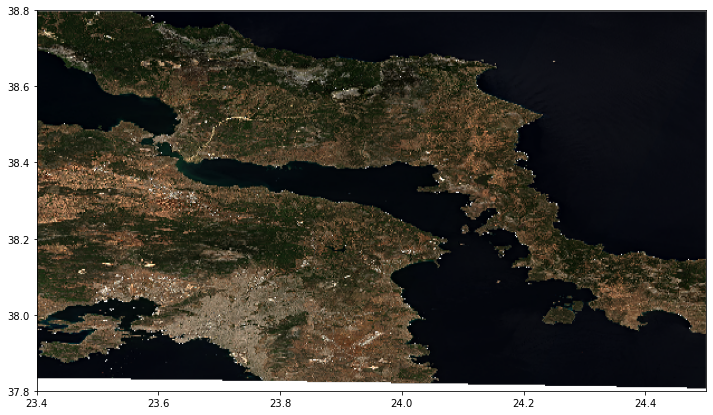

In [29]:
getMap(wms,'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__TRUE_COLOR',(23.4,37.8,24.5,38.8), 'rgb.png')
image1=mpimg.imread('rgb.png')
fig = plt.figure(figsize=(12,7))
img1=plt.imshow(image1,extent=[23.4,24.5,37.8,38.8],aspect='auto')
plt.show()

Alternatively, the Folium library is available to create a Leaflet map with the WMS layer

In [31]:
import os
import folium

print(folium.__version__)

0.12.1


In [84]:
m = folium.Map(location=[37, 14], zoom_start=6, tiles=None)

folium.raster_layers.WmsTileLayer(
    url="https://a.tiles.maps.eox.at",
    layers='terrain-light_3857',
    name='terrain-light',
    fmt='image/jpeg',
).add_to(m)


folium.raster_layers.WmsTileLayer(
    url=wms_endpoint.partition("?")[0],
    layers='S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__TRUE_COLOR',
    name='S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__TRUE_COLOR',
    fmt='image/png',
    transparent=True,
    overlay=True,
    control=True,
).add_to(m)

folium.raster_layers.WmsTileLayer(
    url=wms_endpoint.partition("?")[0],
    layers='S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__outlines',
    name='S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__outlines',
    fmt='image/png',
    transparent=True,
    overlay=True,
    control=True,
).add_to(m)

folium.LayerControl().add_to(m)

m

### Data Download

After discovering and visualizing the dataset, the user can identify the WCS link from the catalogue record and use the OWSLib WCS client to download the dataset

In [93]:
tree = None
for link in links:
    scheme = link['scheme']
    if 'WCS' in scheme:
        print(link['url'])
        wcs_endpoint=link['url'].split('?')[0]
        wcs_id=link['url'].split('eoid=')[1]
        tree = lxml.etree.fromstring(requests.get(link['url']).content)
        break

        

coverage_ids = tree.xpath('wcs:CoverageDescriptions/wcs:CoverageDescription/@gml:id', namespaces=tree.nsmap)
coverage_ids

https://data-access.demo.eoepca.org/ows?service=WCS&version=2.0.1&request=DescribeEOCoverageSet&eoid=S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE


['S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE__B01__coverage',
 'S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE__B02__coverage',
 'S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE__B03__coverage',
 'S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE__B04__coverage',
 'S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE__B05__coverage',
 'S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE__B06__coverage',
 'S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE__B07__coverage',
 'S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE__B08__coverage',
 'S2B_MSIL1C_20210402T095029_N0300_R079_T33SVB_20210402T121737.SAFE__B09__coverage']

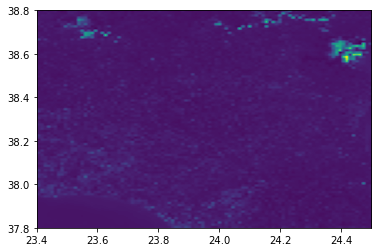

In [63]:
getcoverage_request = wcs_endpoint + '?service=WCS&version=2.0.1&request=GetCoverage&coverageid=' + coverage_ids[1] + '&scaleSize=x(100),y(100)&format=image/tiff'
response = requests.get(getcoverage_request)
response.raise_for_status()

content = response.content
img1 = plt.imshow(imread(BytesIO(content)),extent=[23.4,24.5,37.8,38.8],aspect='auto')
plt.show()

In [86]:
wcs = WebCoverageService(wcs_endpoint, version='2.0.1')

In [94]:
wcs.contents.keys()

dict_keys([])